In [27]:
import pandas as pd
import numpy as np
import torch
import random
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

### Import and explore dataset

In [28]:
NYCdf = pd.read_csv('../scripts/data/NYCschools/final_data_interventions_max_frac.csv')
NYCdf

,AP/IB,Calculus,Counselors,FracSAT/ACT,black,Hispanic,white,lat,long,gis_x,gis_y,neigh1,neigh2,neigh3,neigh4,neigh5
0,1.0,1.0,1.0,0.163317,1,0,0,40.649662,-73.958204,9.958480e+05,175968.536711,132,105,225,144,41
1,1.0,1.0,2.0,0.220657,0,1,0,40.859515,-73.887958,1.015243e+06,252441.989916,283,99,2,270,64
2,1.0,0.0,1.0,0.296588,0,1,0,40.859576,-73.889183,1.014904e+06,252463.809247,99,283,1,270,64
3,1.0,0.0,1.0,0.107330,0,1,0,40.818359,-73.911368,1.008782e+06,237439.880982,191,65,156,307,290
4,1.0,1.0,1.0,0.228381,0,1,0,40.878025,-73.913255,1.008238e+06,259178.021389,271,100,305,8,230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,1.0,1.0,4.0,0.198575,1,0,0,40.744448,-73.728974,1.059350e+06,210615.167144,213,248,275,316,212
341,1.0,0.0,2.0,0.067594,0,1,0,40.774969,-73.986084,9.881044e+05,221619.088133,49,13,343,159,82
342,0.0,0.0,1.0,0.222222,1,0,0,40.698381,-73.745498,1.054820e+06,193818.062362,316,236,243,338,62
343,1.0,0.0,2.6,0.102564,0,1,0,40.774700,-73.985454,9.882789e+05,221521.223661,13,49,341,159,82


In [29]:
NYCdf['Race'] = NYCdf.apply(lambda x: 1 if x['white']==1 else 0, axis=1)

In [30]:
NYCdf = NYCdf[['Race', 'AP/IB', 'Calculus', 'Counselors', 'FracSAT/ACT', 'lat', 'long']]
NYCdf.rename(columns={'Race': 'S', 'AP/IB': 'T', 'Calculus': 'Cl', 'Counselors': 'Cs', 'FracSAT/ACT': 'Y'}, inplace=True)
# 'lat': 'La', 'long': 'Lo'
NYCdf

,S,T,Cl,Cs,Y,lat,long
0,0,1.0,1.0,1.0,0.163317,40.649662,-73.958204
1,0,1.0,1.0,2.0,0.220657,40.859515,-73.887958
2,0,1.0,0.0,1.0,0.296588,40.859576,-73.889183
3,0,1.0,0.0,1.0,0.107330,40.818359,-73.911368
4,0,1.0,1.0,1.0,0.228381,40.878025,-73.913255
...,...,...,...,...,...,...,...
340,0,1.0,1.0,4.0,0.198575,40.744448,-73.728974
341,0,1.0,0.0,2.0,0.067594,40.774969,-73.986084
342,0,0.0,0.0,1.0,0.222222,40.698381,-73.745498
343,0,1.0,0.0,2.6,0.102564,40.774700,-73.985454


In [31]:
# Cs is descrte, how many categories?
len(sorted(NYCdf['Cs'].unique()))

31

<AxesSubplot:xlabel='T', ylabel='Count'>

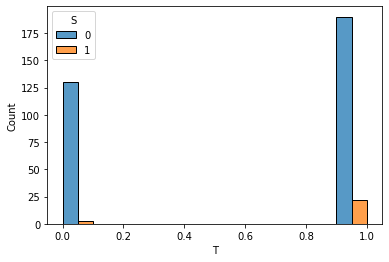

In [32]:
sns.histplot(NYCdf, x = 'T', hue = 'S', multiple = 'dodge')

<AxesSubplot:xlabel='Y', ylabel='Count'>

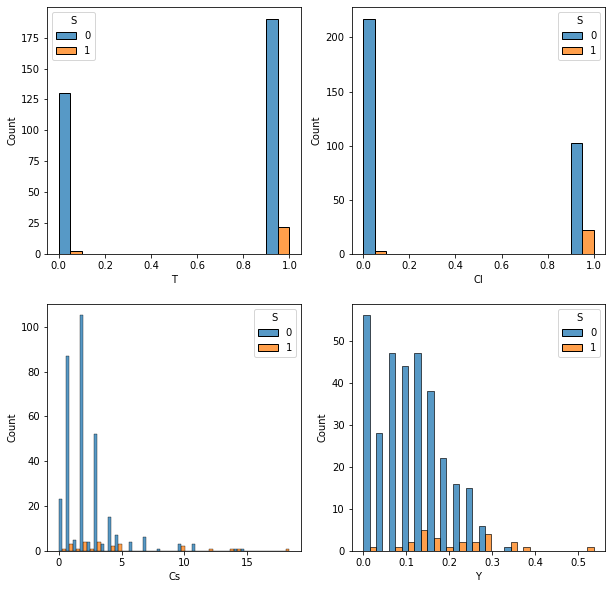

In [33]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (10,10))
sns.histplot(NYCdf, x = 'T', hue = 'S', multiple = 'dodge', ax = axs[0,0])
sns.histplot(NYCdf, x = 'Cl', hue = 'S', multiple = 'dodge', ax = axs[0,1])
sns.histplot(NYCdf, x = 'Cs', hue = 'S', multiple = 'dodge', ax = axs[1,0])
sns.histplot(NYCdf, x = 'Y', hue = 'S', multiple = 'dodge', ax = axs[1,1])

### Create dataset, composedY

In [34]:
def ReLU(x):
    return x * (x > 0)

In [35]:
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)
noise_mean = 0.5
std = 0.4
wx_linear = np.random.rand(3)
ws_linear = np.random.rand(1)
wsx_linear = np.random.rand(3)
beta_non_A = np.random.normal(loc=0.8, scale=std, size=(7, 1))
beta_A = np.random.normal(loc=5, scale=std, size=(8, 1))
gamma_non_A = np.random.normal(loc=0.8, scale=std, size=(3, 1))
gamma_A = np.random.normal(loc=5, scale=std, size=(4, 1))
# print(beta_non_A, gamma_non_A)
beta = np.concatenate((beta_non_A, beta_A), axis=0).squeeze()
gamma = np.concatenate((gamma_non_A, gamma_A), axis=0).squeeze()
print("beta: ", beta)
print("gamma: ", gamma)
X_cols = ['T', 'Cl', 'Cs']
X = NYCdf[X_cols].to_numpy()
y = NYCdf['Y'].to_numpy()
n = len(y)
S = NYCdf['S'].to_numpy().reshape(n, -1)
noise_nonlin = np.random.normal(0.5, std, (n, 1))
# A structural equation
A = (((wsx_linear.dot(X.T) * S.squeeze())**2) + ReLU(wx_linear.dot(X.T))).reshape(-1, 1)
# A + noise
A_noise = A + noise_nonlin.reshape(-1, 1)
# scale to [0,1]
normalimze_nonlin = MinMaxScaler(feature_range=(0, 1)).fit(A_noise)
A_nonlinear_bounded01 = normalimze_nonlin.transform(A_noise)
noise_composed_Y = np.random.normal(1, std, (n, ))
## Create f, g, h
def generate_g(beta, S, X, A, rescale=3):
    return beta.dot(np.concatenate([S, X, S*X, A, X*A, S*A, S*A*X], axis=1).T)/rescale
def generate_h(gamma, A, X):
    return gamma.dot(np.concatenate([X, A, A*X], axis=1).T)
g = generate_g(beta, S, X, A_nonlinear_bounded01)
h = generate_h(gamma, A_nonlinear_bounded01, X)
## Create Y_pi
y0_scale=20
def composed_Y_no_divide(y, g, h, noise, y0_scale=y0_scale):
    return (y0_scale*y + g + h + noise)
Y_strongerA = composed_Y_no_divide(y, g, h, noise_composed_Y)
## Compose the dataframe
NYC_pi_nonlinear_strongerA = \
    np.concatenate((X, S, A_nonlinear_bounded01, A, Y_strongerA.reshape(-1, 1), y.reshape(-1, 1)), axis=1)
NYC_pi_nonlinear_strongerA = \
    pd.DataFrame(NYC_pi_nonlinear_strongerA\
        , columns=['T', 'Cl', 'Cs', 'S', 'A', 'A_mu', 'Y', 'Orig_Y'])
NYC_pi_nonlinear_strongerA['wsx_linear0'] = wsx_linear[0]
NYC_pi_nonlinear_strongerA['wsx_linear1'] = wsx_linear[1]
NYC_pi_nonlinear_strongerA['wsx_linear2'] = wsx_linear[2]
NYC_pi_nonlinear_strongerA['wx_linear0'] = wx_linear[0]
NYC_pi_nonlinear_strongerA['wx_linear1'] = wx_linear[1]
NYC_pi_nonlinear_strongerA['wx_linear2'] = wx_linear[2]

beta:  [ 0.91161652  1.20420611  0.56764875  0.58993208  0.57144793  0.43036686
 -0.24501961  5.38014787  5.32657803  4.3904496   4.82878157  4.70303727
  4.71866248  4.14415174  4.74821002]
gamma:  [1.03908819 1.82379521 0.95769321 5.04888767 4.79382574 4.75989846
 5.37897593]


In [36]:
print("Mean of Y:", Y_strongerA.mean())
print("MinA:", min(A_noise))
print("RangeA:", max(A_noise) - min(A_noise))

Mean of Y: 16.120714685827462
MinA: [0.11479375]
RangeA: [16.88043813]


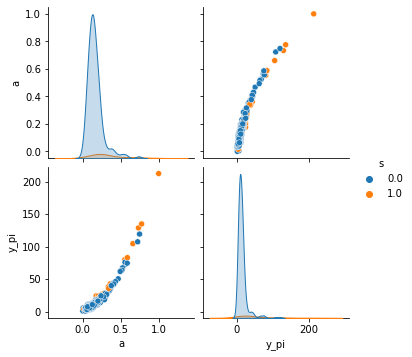

In [37]:
df_actions = pd.DataFrame(np.concatenate((A_nonlinear_bounded01, S, Y_strongerA.reshape(-1, 1)), axis=1), columns=['a', 's', 'y_pi'])
sns.pairplot(df_actions, hue='s')

In [38]:
A_0s = np.zeros(A_nonlinear_bounded01.shape)
A_03s = np.full(A_nonlinear_bounded01.shape, 0.3)

mean y_0 A0 response:  0.12052004084233518
mean y_0 s0: 0.11329623363334092, s1: 0.21298477311746186
mean Y A0 response:  7.930005773674408
mean Y s0: 7.41930840104296, s1: 14.466932143356923
mean g A0 response:  0.8243265562809097
mean g s0: 0.755327677258832, s1: 1.7075122077635034
mean h A0 response:  3.715747928592916
mean h s0: 3.4252423809366603, s1: 7.434218938592986


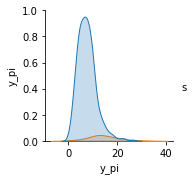

In [39]:
g_A0s = generate_g(beta, S, X, A_0s)
h_A0s = generate_h(gamma, A_0s, X)
## Create Y_pi
Y_A0s = composed_Y_no_divide(y, g_A0s, h_A0s, noise_composed_Y)
print("mean y_0 A0 response: ", np.mean(y))
print("mean y_0 s0: {}, s1: {}".format(y[S.squeeze()==0].mean(), y[S.squeeze()==1].mean()))
print("mean Y A0 response: ", np.mean(Y_A0s))
print("mean Y s0: {}, s1: {}".format(Y_A0s[S.squeeze()==0].mean(), Y_A0s[S.squeeze()==1].mean()))
print("mean g A0 response: ", np.mean(g_A0s))
print("mean g s0: {}, s1: {}".format(g_A0s[S.squeeze()==0].mean(), g_A0s[S.squeeze()==1].mean()))
print("mean h A0 response: ", np.mean(h_A0s))
print("mean h s0: {}, s1: {}".format(h_A0s[S.squeeze()==0].mean(), h_A0s[S.squeeze()==1].mean()))
# boot_Y_A0s.shape
df = pd.DataFrame(np.concatenate((Y_A0s.reshape(-1,1), S.reshape(-1, 1)), axis=1), columns=['y_pi', 's'])
sns.pairplot(df, hue='s')

mean Y A03 response:  17.427405417306137
mean Y s0: 16.105834774073276, s1: 34.34350965068676
mean g A03 response:  3.334297370487915
mean g s0: 2.870901158154047, s1: 9.265768888361409
mean h A03 response:  3.715747928592916
mean h s0: 9.99619527307176, s1: 19.752539765324922


(array([ 94., 147.,  66.,  19.,   5.,   8.,   2.,   3.,   0.,   1.]),
 array([ 2.76967139, 11.02114968, 19.27262797, 27.52410627, 35.77558456,
        44.02706285, 52.27854114, 60.53001944, 68.78149773, 77.03297602,
        85.28445432]),
 <BarContainer object of 10 artists>)

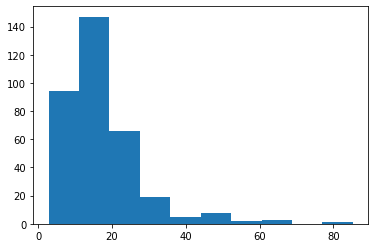

In [40]:
g_A03s = generate_g(beta, S, X, A_03s)
h_A03s = generate_h(gamma, A_03s, X)
## Create Y_pi
Y_A03s = composed_Y_no_divide(y, g_A03s, h_A03s, noise_composed_Y)
print("mean Y A03 response: ", np.mean(Y_A03s))
print("mean Y s0: {}, s1: {}".format(Y_A03s[S.squeeze()==0].mean(), Y_A03s[S.squeeze()==1].mean()))
print("mean g A03 response: ", np.mean(g_A03s))
print("mean g s0: {}, s1: {}".format(g_A03s[S.squeeze()==0].mean(), g_A03s[S.squeeze()==1].mean()))
print("mean h A03 response: ", np.mean(h_A0s))
print("mean h s0: {}, s1: {}".format(h_A03s[S.squeeze()==0].mean(), h_A03s[S.squeeze()==1].mean()))
plt.hist(Y_A03s)

In [41]:
oracle_params = [wsx_linear, wx_linear, np.array([noise_mean]), beta, gamma]

In [42]:
import pickle
pkl_filename = "../scripts/data/NYCschools/pi_nonlinear_strongerA_oracle_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(oracle_params, file)
np.savez_compressed('../scripts/data/NYCschools/simY_pi_nonlinear_strongerA_all.npz',NYC_pi_nonlinear_strongerA)